# Autoencoders para Colorear Imagenes en Escalas de Grises
---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    LOCAL_DIR = './DATOS/'  # carpeta local en maquina virtual
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../../DATOS/' # carpeta donde se encuentran los datasets
    LOCAL_DIR = DATOS_DIR

MODELOS_DIR = DATOS_DIR + '../MODELOS/'

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Mounted at /content/drive/


**Inclusión de paquetes**

In [2]:
import numpy as np
import re
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm
from zipfile import ZipFile
from PIL import Image
import glob

**Preparación del Archivo de Datos**

Recupera el archivo comprimido de la carpeta de g-drive y lo descomprime en una carpeta local para hacer más rápido el acceso a las imágenes.

In [3]:
ZIP_ARCH = 'landscape_color_gray.zip' # archivo comprimido

# Verificar y crear la carpeta de datos local si no existe
if not os.path.exists(LOCAL_DIR):
    os.makedirs(LOCAL_DIR)

# Comprueba la existencia del archivo en la carpeta de destino
if not os.path.exists(os.path.join(LOCAL_DIR, ZIP_ARCH)):
    # Ruta completa del archivo origen
    source_file = os.path.join(DATOS_DIR, ZIP_ARCH)

    shutil.copy(source_file, LOCAL_DIR) # Copiar el archivo a la carpeta local de datos

    # Descomprimir el archivo ZIP
    with ZipFile(os.path.join(LOCAL_DIR, ZIP_ARCH), 'r') as zip_ref:
        zip_ref.extractall(LOCAL_DIR)
        print(f"El archivo {ZIP_ARCH} se ha copiado y descomprimido en {LOCAL_DIR}.")

El archivo landscape_color_gray.zip se ha copiado y descomprimido en ./DATOS/.


In [4]:
SIZE = 96  # Tamaño de la imagen que será procesada por la red
GRAY_CHANNELS = 1
color_img = []
gray_img = []

ruta_color = 'landscape Images/color/'
ruta_grises = 'landscape Images/gray/'

archivos = glob.glob(LOCAL_DIR + ruta_color + '*.jpg')

for ruta_arch in tqdm(archivos):
    # Imagen en color
    img_color = Image.open(ruta_arch)
    img_color = img_color.convert('RGB')  # Convertir a formato RGB si no lo está
    img_color = img_color.resize((SIZE, SIZE))  # Cambiar tamaño
    img_color = np.array(img_color)  # Convertir a arreglo numpy
    img_color = img_color.astype('float32') / 255.0  # Normalizar
    color_img.append(img_color)

    # Imagen en escala de grises
    ruta_gris = ruta_arch.replace('color', 'gray')
    img_gray = Image.open(ruta_gris)
    img_gray = img_gray.resize((SIZE, SIZE))  # Cambiar tamaño

    if GRAY_CHANNELS == 3:
        if img_gray.mode != 'RGB':
            img_gray = img_gray.convert('RGB')
        else:
            pass
    elif img_gray.mode != 'L':
            img_gray = img_gray.convert('L')
            print('convirtio')
    img_gray = np.array(img_gray)  # Convertir a arreglo numpy
    img_gray = img_gray.astype('float32') / 255.0  # Normalizar
    #img_gray = np.expand_dims(img_gray, axis=-1)  # Agregar dimensión de canal
    gray_img.append(img_gray)

print(img_gray.shape)

100%|██████████| 7129/7129 [00:13<00:00, 540.62it/s]

(96, 96)


**Gráficar Algunas Imagenes**

Gráfico en escalas de grises y su versión correspondiente en color

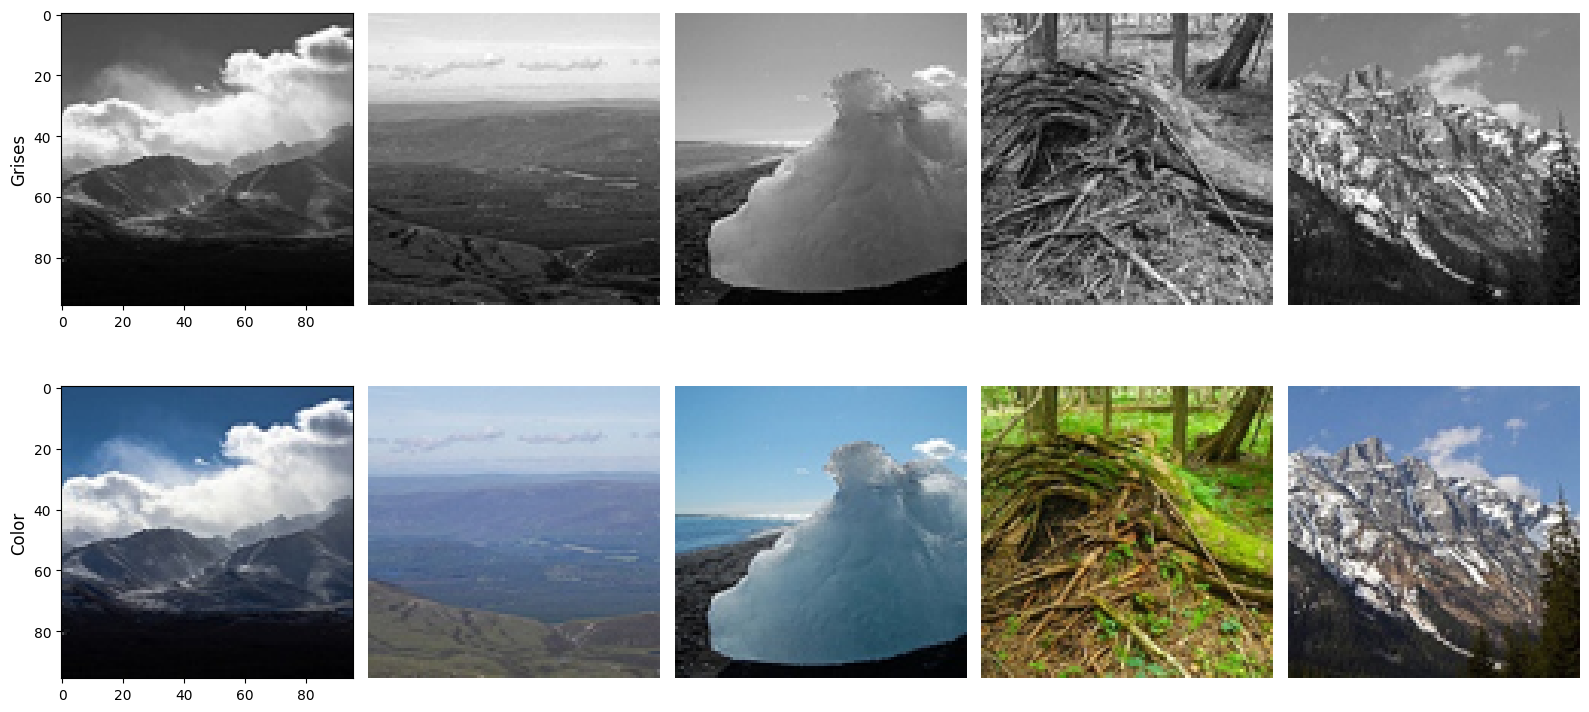

(96, 96)

In [5]:
# Definir una función para mostrar imágenes en dos filas
def plot_images(grayscale_images, color_images, num_images):

    fig, axes = plt.subplots(2, num_images, figsize=(16, 8))

    # Dibujar imágenes en escala de grises en la segunda fila
    for i in range(num_images):
        axes[0, i].imshow(grayscale_images[i], cmap='gray')
        #axes[1, i].set_title('Grayscale Image', color='black', fontsize=12)
        axes[0, i].axis('off')

    # Dibujar imágenes en color en la primera fila
    for i in range(num_images):
        axes[1, i].imshow(color_images[i])
        #axes[0, i].set_title('Color Image', color='green', fontsize=12)
        axes[1, i].axis('off')

    # Agregar títulos
    axes[0, 0].set_ylabel('Grises' , fontsize=12)
    axes[1, 0].set_ylabel('Color', fontsize=12)
    axes[0, 0].axis('on')
    axes[1, 0].axis('on')


    plt.tight_layout()
    plt.show()

plot_images(gray_img, color_img, 5)
gray_img[0].shape

**Separa en datos de entrenamiento y prueba**

Separa ambos grupos de imagenes en entrenamiento y prueba. Es importante que los indices

In [6]:
NUM_IMGS = len(gray_img)
NUM_TRAIN = int(NUM_IMGS * 0.9)


train_gray_img = gray_img[:NUM_TRAIN]
train_color_img = color_img[:NUM_TRAIN]

test_gray_img = gray_img[NUM_TRAIN:]
test_color_img = color_img[NUM_TRAIN:]

# estructura para dar formato para procesar por la red
train_gray_img = np.reshape(train_gray_img, (-1, SIZE, SIZE, GRAY_CHANNELS))
train_color_img = np.reshape(train_color_img, (-1, SIZE, SIZE, 3))
print('Shape de imagenes de entrenamiento:', train_color_img.shape)

test_gray_img = np.reshape(test_gray_img, (len(test_gray_img), SIZE, SIZE, GRAY_CHANNELS))
test_color_img = np.reshape(test_color_img, (-1, SIZE, SIZE, 3))
print('Shape de imagenes de prueba.......:', test_color_img.shape)

Shape de imagenes de entrenamiento: (6416, 96, 96, 3)
Shape de imagenes de prueba.......: (713, 96, 96, 3)


### Callback para visualizar

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
from IPython import display
import io
import base64
import random

class ImageVisualizer(Callback):
    """
    Callback para visualizar imágenes durante el entrenamiento de un modelo.

    Parameters:
        model (Model): El modelo de Keras que se está entrenando.
        in_images (ndarray): Las imágenes de entrada.
        ref_images (ndarray, optional): Las imágenes de referencia. Por defecto es None.
        show_images (int, optional): Número de imágenes a mostrar. Por defecto es 5.
        interval (int, optional): Intervalo de épocas para actualizar las imágenes. Por defecto es 1.
        draw_input (bool, optional): Si se deben dibujar las imágenes de entrada. Por defecto es False.
        fig_size (tuple, optional): Tamaño de la figura. Si es None, se calcula automáticamente. Por defecto es None.
    """
    def __init__(self, model, in_images, ref_images=None, show_images=5, interval=1, draw_input=False, fig_size=None):
        super(ImageVisualizer, self).__init__()
        plt.ioff()
        self.model = model
        self.images = in_images
        self.ref_images = ref_images
        self.show_images = show_images
        self.interval = interval
        self.draw_input = draw_input

        (num_rows, num_cols) = (1 + draw_input + (ref_images is not None)*1, show_images)
        if fig_size is None:
            fig_size = (num_cols * 2.5, num_rows * 3)

        self.fig, self.ax = plt.subplots(num_rows, num_cols, figsize=fig_size, squeeze=False)

        self.display_obj = display.display(display.HTML(''), display_id = True)


    def _update_output(self):
        # Guarda el gráfico en un búfer de memoria
        buf = io.BytesIO()
        self.fig.savefig(buf, format='png')
        buf.seek(0)

        # Codifica el gráfico en base64
        image_base64 = base64.b64encode(buf.read()).decode('utf-8')

        data = {'image/png': image_base64}
        # Actualizar el gráfico
        display.update_display(data, raw=True, display_id=self.display_obj.display_id)

    def _plot_image(self, ax, title, img):
        """
        Dibuja una imagen en un eje específico.

        Parameters:
            ax (Axes): El eje en el que se dibujará la imagen.
            title (str): El título de la imagen.
            img (ndarray): La imagen a dibujar.
        """

        cmap = 'gray' if img.shape[-1] == 1 else None

        # Normalizar imagen original
        img = img.squeeze()
        if img.max() > 1:
            img = img / 255.0

        ax.imshow(img, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval == 0:
            output_row =  1 if self.draw_input else 0
            refer_row = output_row +1
            rnd_idx = random.sample(range(len(self.images)), self.show_images)
            inp_imgs = self.images[rnd_idx]
            ref_imgs = self.ref_images[rnd_idx]
            #
            output_imgs = self.model.predict(inp_imgs, verbose=False)

            for i in range(self.show_images):

                if self.draw_input:
                    self._plot_image(self.ax[0, i], 'Input', inp_imgs[i])

                # mostrar imagen de salida
                self._plot_image(self.ax[output_row, i], 'Output', output_imgs[i])

                if self.ref_images is not None:
                    self._plot_image(self.ax[refer_row, i], 'Reference', ref_imgs[i])

            # Agregar título general con el número de época
            title_parts = [f"Época {epoch}"]

            for metric, value in logs.items():
                if metric != 'batch' and metric != 'size':  # Excluir métricas no deseadas
                    title_parts.append(f"{metric.capitalize()}: {value:.4f}")

            self.fig.text(0.5, 0.05, " - ".join(title_parts), ha='center', va='bottom', fontsize=14,
                          bbox=dict(facecolor='white', edgecolor='none', pad=5, alpha=1.0)
                         )
            self._update_output()

    def on_train_end(self, logs=None):
        plt.close()


**Construccion del modelo**

Construye el modelo utilizando capas convolucionales que reducen el tamaño de la imagen a través del stride e incrementan la cantidad de filtros hasta llegar al espacio de representación latente. Luego se realiza el proceso inverso agregando capas convolucionales que decrementan la cantidad de filtros y capas de Upsampling para ir recuperando el tamaño de la imagen al original.

In [8]:
import tensorflow as tf

def saturation_loss(y_true, y_pred):
    # Convertir las imágenes de RGB a HSV
    y_true_hsv = tf.image.rgb_to_hsv(y_true)
    y_pred_hsv = tf.image.rgb_to_hsv(y_pred)

    # Extraer la saturación (segunda canal en HSV)
    saturation_true = y_true_hsv[:, :, :, 1]
    saturation_pred = y_pred_hsv[:, :, :, 1]

    # Calcular la diferencia de saturación
    saturation_diff = tf.abs(saturation_true - saturation_pred)

    # Promediar la diferencia de saturación en todas las imágenes
    saturation_loss = tf.reduce_mean(saturation_diff)

    return saturation_loss


def total_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    sat_loss = saturation_loss(y_true, y_pred)

    # Combinar las pérdidas (puedes ajustar los pesos según sea necesario)
    total_loss = mse_loss + 0.2 * sat_loss  # Ajusta el peso de la pérdida de saturación

    return total_loss


In [9]:
from  tensorflow.keras import models
import tensorflow as tf
from tensorflow.keras import mixed_precision


def crear_modelo1(img_h, img_w, img_ch, activ='relu', filt=64):
    # codificador
    inputs1 = layers.Input(shape=(img_h, img_w, img_ch,))
    encoder_output = layers.Conv2D(filt, (3,3), activation=activ, padding='same', strides=2)(inputs1)
    encoder_output = layers.Conv2D(2*filt, (3,3), activation=activ, padding='same', strides=2)(encoder_output)
    encoder_output = layers.Conv2D(4*filt, (3,3), activation=activ, padding='same')(encoder_output)

    # decodificador
    decoder_output = layers.Conv2D(4*filt, (3,3), activation=activ, padding='same')(encoder_output)
    decoder_output = layers.Conv2DTranspose(4*filt, (3,3),padding = 'same', strides = 2)(decoder_output)
    decoder_output = layers.Conv2D(2*filt, (3,3), activation=activ, padding='same')(decoder_output)
    decoder_output = layers.Conv2DTranspose(2*filt, (3,3),padding = 'same', strides = 2)(decoder_output)
    decoder_output = layers.Conv2D(filt, (3,3), activation=activ, padding='same')(decoder_output)
    decoder_output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoder_output)

    model = models.Model(inputs=inputs1, outputs=decoder_output)

    return model

def crear_modelo2(img_h, img_w, img_ch, activ='relu', filt=64):
    # codificador
    inputs1 = layers.Input(shape=(img_h, img_w, img_ch,))
    encoder_output = layers.Conv2D(filt, (5,5), activation=activ, padding='same')(inputs1)
    encoder_output = layers.MaxPooling2D((2,2))(encoder_output)
    encoder_output = layers.Conv2D(2*filt, (3,3), activation=activ, padding='same')(encoder_output)
    encoder_output = layers.MaxPooling2D((2,2))(encoder_output)
    encoder_output = layers.Conv2D(4*filt, (3,3), activation=activ, padding='same')(encoder_output)

    # decodificador
    decoder_output = layers.Conv2D(4*filt, (3,3), activation=activ, padding='same')(encoder_output)
    decoder_output = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(decoder_output)
    decoder_output = layers.Conv2D(2*filt, (3,3), activation=activ, padding='same')(decoder_output)
    decoder_output = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(decoder_output)
    decoder_output = layers.Conv2D(filt, (3,3), activation=activ, padding='same')(decoder_output)
    decoder_output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoder_output)

    model = models.Model(inputs=inputs1, outputs=decoder_output)

    return model

model = crear_modelo1(SIZE, SIZE, GRAY_CHANNELS, activ='relu', filt=32)
#model = crear_modelo2(SIZE, SIZE, GRAY_CHANNELS, activ='relu', filt=32)

# Compilar y entrenar el modelo utilizando el generador de datos OJO: Tiene funcion de pérdida
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=total_loss)

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       147584    
                                                                 
 conv2d_transpose (Conv2DTr  (None, 48, 48, 128)       147584    
 anspose)                                                        
                                                             

**Entrenamiento**

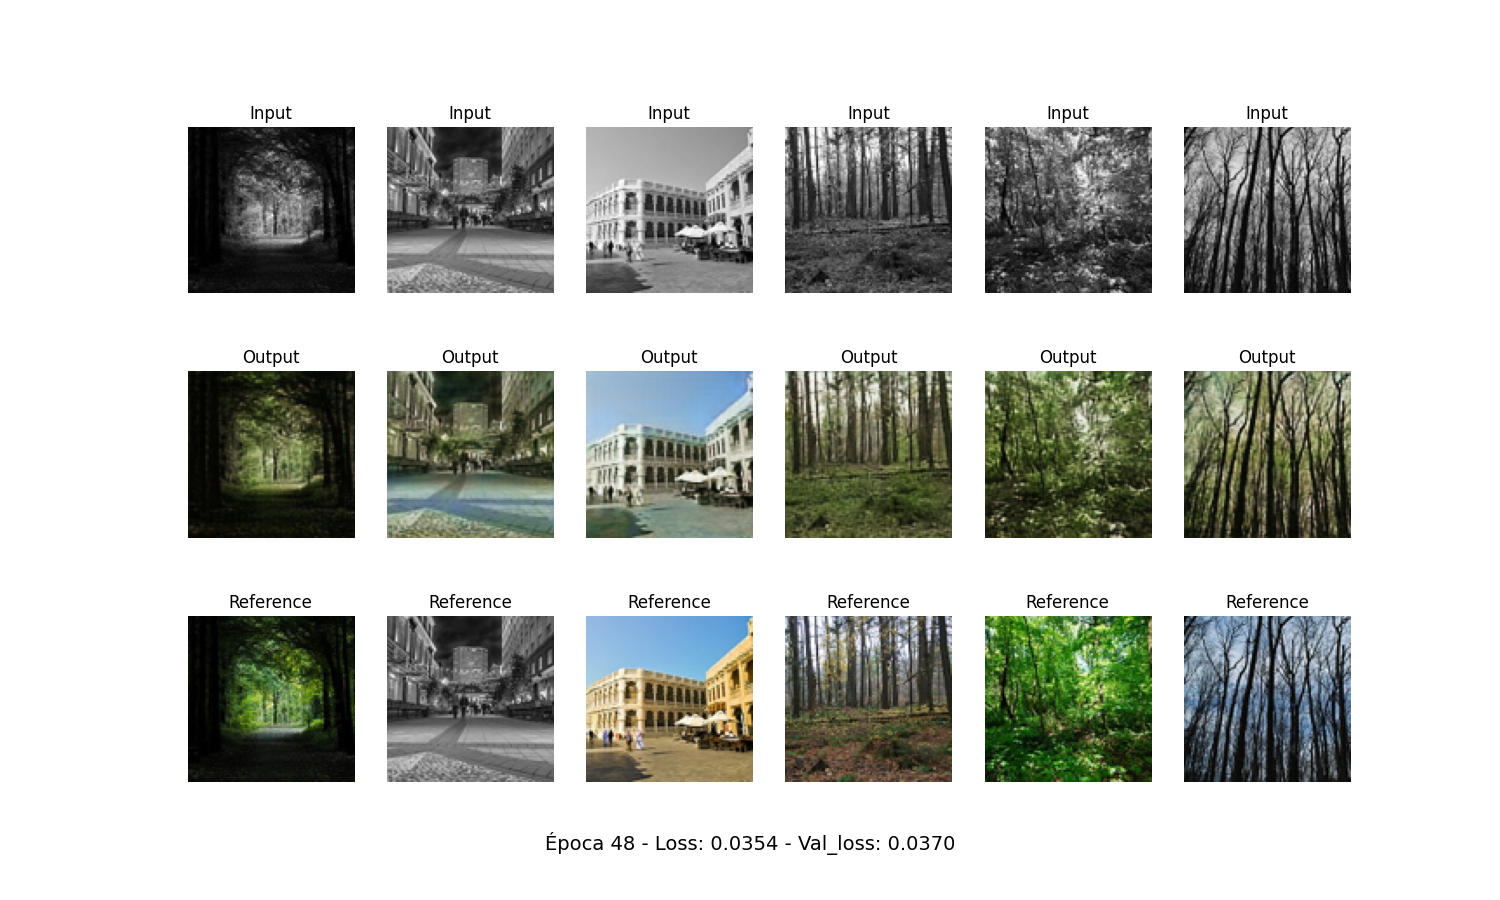

Epoch 1/200
257/257 [==============================] - 24s 55ms/step - loss: 0.0612 - val_loss: 0.0490
Epoch 2/200
257/257 [==============================] - 11s 42ms/step - loss: 0.0474 - val_loss: 0.0443
Epoch 3/200
257/257 [==============================] - 10s 39ms/step - loss: 0.0449 - val_loss: 0.0427
Epoch 4/200
257/257 [==============================] - 11s 42ms/step - loss: 0.0441 - val_loss: 0.0435
Epoch 5/200
257/257 [==============================] - 12s 45ms/step - loss: 0.0434 - val_loss: 0.0422
Epoch 6/200
257/257 [==============================] - 11s 43ms/step - loss: 0.0428 - val_loss: 0.0431
Epoch 7/200
257/257 [==============================] - 11s 44ms/step - loss: 0.0420 - val_loss: 0.0404
Epoch 8/200
257/257 [==============================] - 11s 41ms/step - loss: 0.0414 - val_loss: 0.0409
Epoch 9/200
257/257 [==============================] - 11s 43ms/step - loss: 0.0411 - val_loss: 0.0412
Epoch 10/200
257/257 [==============================] - 11s 42ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
import random
from tensorflow.keras.callbacks import EarlyStopping

# Callback para parada temprana
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True)

# Definimos el callback para visualizar
visualizer = ImageVisualizer(model, train_gray_img, train_color_img, show_images=6, draw_input=True)

model.fit(train_gray_img,
          train_color_img,
          validation_split=0.2,
          epochs = 200,
          batch_size = 20,
          verbose = 1,
          callbacks=[early_stop, visualizer])

model.save(MODELOS_DIR + 'Autoencoder_colorear_1.h5')

**Evaluación con datos de prueba**

In [11]:
model.evaluate(test_gray_img, test_color_img)

23/23 [==============================] - 2s 40ms/step - loss: 0.0370


0.03700525313615799

**Visualización de Resultados**

Muestra varias imagenes en escalas de grises con la versión de su imagen a color y la versión de la imagen coloreada

23/23 [==============================] - 0s 16ms/step


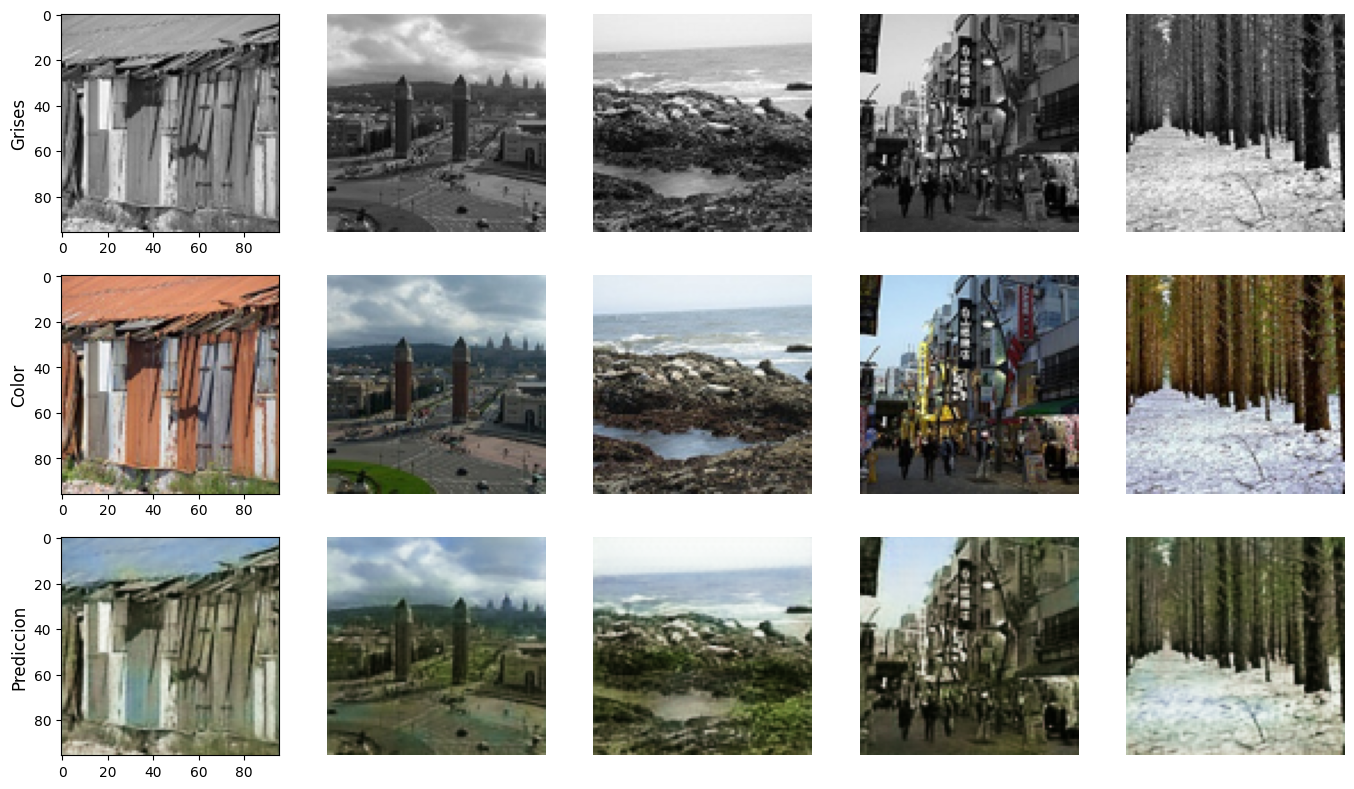

In [12]:
# Definir una función para mostrar imágenes en dos filas
def plot_images(grayscale_img, color_img, predicted_img, ini_img, num_img):

    fig, axes = plt.subplots(3, num_img, figsize=(14, 8))

    # Dibujar imágenes en escala de grises en la segunda fila
    for i in range(num_img):
        axes[0, i].imshow(grayscale_img[ini_img+i], cmap='gray')

        axes[0, i].axis('off')

     # Dibujar imágenes en color en la primera fila
    for i in range(num_img):
        axes[1, i].imshow(color_img[ini_img+i])
        axes[1, i].axis('off')

    # Dibujar imágenes en color en la primera fila
    for i in range(num_img):
        axes[2, i].imshow(predicted_img[ini_img+i])
        axes[2, i].axis('off')

    # Agregar títulos
    axes[0, 0].set_ylabel('Grises' , fontsize=12)
    axes[1, 0].set_ylabel('Color', fontsize=12)
    axes[2, 0].set_ylabel('Prediccion', fontsize=12)
    axes[0, 0].axis('on')
    axes[1, 0].axis('on')
    axes[2, 0].axis('on')

    plt.tight_layout()
    plt.show()


ini_imgs = 6
num_imgs = 5

# obtiene imágenes coloreadas del dataset de prueba a partir de imagenes en escala de grises
predicted_img = model.predict(test_gray_img)

plot_images(test_gray_img, test_color_img, predicted_img, ini_imgs, num_imgs)